## LLM - models - Chatgpt

In this notebook I use OpenAI API (batch mode) to get:
1. Direct answer about LLM's prediction if this is clickbait or not
2. Embeddings from llm to build model based on this.

Things that may be improved:
 1. Embeddings
    * try different embeddings dimensions (1000?, ...)
    * fine tuning of RF or xGboost
 2. Direct call
     * play with prompt
     * play with temperature, and other parameters of models 

In [20]:
# TODO: -> LLM Models (chat gpt api, bert?)

In [21]:
# DATA PROCESSING, VISUALIZATION
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import string
import re

# MODELS, MODEL EVALUATION
from openai import OpenAI
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

import os
import json
from typing import List
import requests
import time
from tqdm import tqdm

In [22]:
df_merged = pd.read_csv("../data/merged_datasetes_balanced_huge.csv")

In [36]:
%run 0-Function-Helper.ipynb

In [23]:
x_train, x_test, y_train, y_test = train_test_split(
    df_merged["title"], 
    df_merged["clickbait"],
    test_size=0.2, 
    random_state=42
)

In [24]:
x_test, x_val, y_test, y_val = train_test_split(
    x_test, 
    y_test,
    test_size=0.5,  # 50% of the original x_test size for validation
    random_state=42,
    stratify=y_test
)

### Setting OpenAI 

In [25]:
with open("../file_path.txt", 'r') as file:
    file_path = file.read()

with open(file_path, 'r') as file:
    api_key = file.read()

In [26]:
client = OpenAI(
    api_key=api_key,
)

In [27]:
for req in client.batches.list(limit=5):
    print(req.metadata)
    print(req.output_file_id)
    print()

{'description': 'request_direct_test_1'}
file-8FidiNqHNoDEaRN7V9IM8ElL

{'description': 'request_direct_test_1'}
file-1y4NvnE0ekgGs8mn9eo8iDpD

{'description': 'request_embeddings_train_1'}
file-YgKZUOZgNBk2eZRhssT30d7g

{'description': 'full data embeddings train full_2'}
file-6HO8OKRsbcmfIyBEGVU9NdxL

{'description': 'full data'}
file-xmssGvqJCzDPlG0Ay4k7m4TV

{'description': 'full data'}
None

{'description': 'full data embeddings test_full_2'}
file-n1oSbiOpnd2UWTY5AAUhSadu

{'description': 'full data embeddings train full_2'}
file-U2AxJkwpe21CiGX2TNiw33xs

{'description': 'full data embeddings train full'}
file-3J8wSNhSYpwAWSHRnvzEWFDg

{'description': 'full data embeddings train_1'}
file-BXkzxUp5nl9aYWN9x6o0sIhV

{'description': 'full data embeddings test'}
file-VdeFVPfsSPCTVe5jfIpGITKP

{'description': 'full data'}
file-XPuAcYx9IdGDslC2LnnEE66J

{'description': 'nightly eval job_real'}
file-c9F5Br1u1qK8VshAraUouPSC

{'description': 'nightly eval job_real'}
None

{'description': '

In [28]:
# Show full way of thinking and improving the prompt and considerations in paper. :)
#  You can play with temperature, and other params, prompt, ...

# Direct prompt 

In [29]:
prompt = """You are an assistant tasked with classifying article titles as either clickbait or legitimate. Your response should be precise and straightforward: respond with only "1" if the news title appears to be clickbait, and only "0" if it seems legitimate. Do not include any additional text, explanations, or reasoning in your response.

Here are some examples:

Title: "You Won't Believe What Happened When This Dog Went to the Park!"
Response: 1

Title: "Scientists Discover New Species in the Amazon Rainforest"
Response: 0

Title: "10 Life Hacks That Will Change the Way You Live Forever"
Response: 1

Title: "Government Announces New Infrastructure Plan for 2024"
Response: 0

Title: "The Shocking Truth Behind Your Morning Coffee!"
Response: 1

Title: "Local School Wins National Award for Academic Excellence"
Response: 0
Here is the title that you need to classify: 
"""


### CREATE REQUEST FILE FOR DIRECT PROMPT

In [30]:
prompts_val = [str(prompt + title) for title in x_val.tolist()]

In [31]:
prompts_val[0]

'You are an assistant tasked with classifying article titles as either clickbait or legitimate. Your response should be precise and straightforward: respond with only "1" if the news title appears to be clickbait, and only "0" if it seems legitimate. Do not include any additional text, explanations, or reasoning in your response.\n\nHere are some examples:\n\nTitle: "You Won\'t Believe What Happened When This Dog Went to the Park!"\nResponse: 1\n\nTitle: "Scientists Discover New Species in the Amazon Rainforest"\nResponse: 0\n\nTitle: "10 Life Hacks That Will Change the Way You Live Forever"\nResponse: 1\n\nTitle: "Government Announces New Infrastructure Plan for 2024"\nResponse: 0\n\nTitle: "The Shocking Truth Behind Your Morning Coffee!"\nResponse: 1\n\nTitle: "Local School Wins National Award for Academic Excellence"\nResponse: 0\nHere is the title that you need to classify: \nArtists Record Joan Manuel Serrat\'s \'Mediterraneo\' for Refugees: Watch'

In [32]:
def create_batch_request_to_open_ai_direct_prompt(
    list_of_prompts: List[str],
    name_of_request_file: str,
    description_of_request: str,   
):

    dictionary = [{
        "custom_id": f"request{i}", 
        "method": "POST", 
        "url": "/v1/chat/completions", 
        "body": {"model": "gpt-4o-mini", 
                 "messages": [
                     {"role": "system", "content": "assistant."},
                     {"role": "user", "content": prompt}],
                 "max_tokens": 1000}
    } for i, prompt in enumerate(prompts_val)]
    
    with open(f"../request_files_openai/{name_of_request_file}.jsonl", "w") as outfile:
        for request__ in dictionary:
            json.dump(request__, outfile)
            outfile.write('\n')
    
    
    batch_input_file = client.files.create(
      file=open(fr"../request_files_openai/{name_of_request_file}.jsonl", "rb"),
      purpose="batch"
    )
    
    return client.batches.create(
        input_file_id=batch_input_file.id,
        endpoint="/v1/chat/completions",
        completion_window="24h",
        metadata={
          "description": description_of_request
        }
    )

In [33]:
request_direct = create_batch_request_to_open_ai_direct_prompt(
    list_of_prompts=prompts_val,
    name_of_request_file="request_direct_val_1",
    description_of_request="request_direct_val_1"
)
print(client.batches.retrieve(request_direct.id))

Batch(id='batch_672f9bdede048190ab676f78ef859c54', completion_window='24h', created_at=1731173342, endpoint='/v1/chat/completions', input_file_id='file-bXKzd5CAynHcY4jiB6RjGpDg', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1731259742, failed_at=None, finalizing_at=None, in_progress_at=None, metadata={'description': 'request_direct_val_1'}, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0))


In [70]:
print(client.batches.retrieve(request_direct.id))

Batch(id='batch_672f9bdede048190ab676f78ef859c54', completion_window='24h', created_at=1731173342, endpoint='/v1/chat/completions', input_file_id='file-bXKzd5CAynHcY4jiB6RjGpDg', object='batch', status='completed', cancelled_at=None, cancelling_at=None, completed_at=1731174787, error_file_id=None, errors=None, expired_at=None, expires_at=1731259742, failed_at=None, finalizing_at=1731174536, in_progress_at=1731173344, metadata={'description': 'request_direct_val_1'}, output_file_id='file-Udjo8SDegiWRbrqZMtkpwudL', request_counts=BatchRequestCounts(completed=4000, failed=0, total=4000))


In [34]:
print(client.batches.retrieve(request_direct.id).output_file_id)

None


In [71]:
# file_response = client.files.content(client.batches.retrieve(request_direct.id).output_file_id)
file_response = client.files.content("file-Udjo8SDegiWRbrqZMtkpwudL")

pred = []
for line in file_response.text.splitlines():
    prediction_str = json.loads(line)['response']['body']['choices'][0]['message']['content']
    pred.append(int(prediction_str))
len(pred)

4000

{'Accuracy': 0.77975, 'Precision': 0.7889812889812889, 'Recall': 0.7616658304064224, 'F1 Score': 0.7750829716619861, 'ROC-AUC': None}

              precision    recall  f1-score   support

           0       0.77      0.80      0.78      2007
           1       0.79      0.76      0.78      1993

    accuracy                           0.78      4000
   macro avg       0.78      0.78      0.78      4000
weighted avg       0.78      0.78      0.78      4000



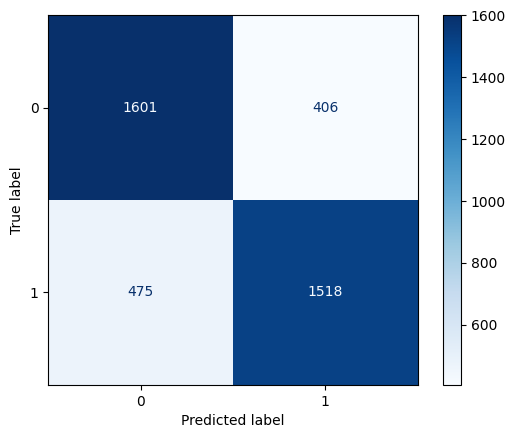

In [73]:
create_summary_for_model_metrics(y_val, pred, None)

# Embeddings

In [39]:
def create_batch_request_to_open_ai_embeddings(
    list_of_texts: List[str],
    name_of_request_file: str,
    description_of_request: str,   
):
    """Function that creates .jsonl file with appropriate format and then sends call to create embeddings using batches"""
    
    dictionary_req = [{
        "custom_id": f"request{i}", 
        "method": "POST", 
        "url": "/v1/embeddings", 
        "body": {"model": "text-embedding-3-large",
                 "input": f"{prompt}"
                }
    } for i, prompt in enumerate(list_of_texts)]
    
    with open(f"../request_files_openai/{name_of_request_file}.jsonl", "w") as outfile:
        for request__ in dictionary_req:
            json.dump(request__, outfile)
            outfile.write('\n')
    
    batch_input_file = client.files.create(
      file=open(fr"../request_files_openai/{name_of_request_file}.jsonl", "rb"),
      purpose="batch"
    )
    
    return client.batches.create(
        input_file_id=batch_input_file.id,
        endpoint="/v1/embeddings",
        completion_window="24h",
        metadata={
          "description": description_of_request
        }
    )
    

## Getting embeddings for train

In [53]:
batch_request_train = create_batch_request_to_open_ai_embeddings(
    list_of_texts = x_train.tolist(),
    name_of_request_file = "request_embeddings_train_1",
    description_of_request = "request_embeddings_train_1"
)
print(batch_request_train)

Batch(id='batch_672f9fbd7f98819084be6c33b19c9feb', completion_window='24h', created_at=1731174333, endpoint='/v1/embeddings', input_file_id='file-awuvLe54PsiEezQRqRNrbJPL', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1731260733, failed_at=None, finalizing_at=None, in_progress_at=None, metadata={'description': 'request_embeddings_train_1'}, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0))


In [85]:
print(batch_request_train)

Batch(id='batch_672f9fbd7f98819084be6c33b19c9feb', completion_window='24h', created_at=1731174333, endpoint='/v1/embeddings', input_file_id='file-awuvLe54PsiEezQRqRNrbJPL', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1731260733, failed_at=None, finalizing_at=None, in_progress_at=None, metadata={'description': 'request_embeddings_train_1'}, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0))


In [45]:
# file_response = client.files.content(client.batches.retrieve(request_direct.id).output_file_id)
file_response = client.files.content("file-6HO8OKRsbcmfIyBEGVU9NdxL")

In [51]:
embeddings_x_train_df = []

for line in tqdm(file_response.text.splitlines(), desc="Processing lines"):
    embeddings_x_train_df.append(json.loads(line)['response']['body']['data'][0]['embedding'])

print(len(embeddings_x_train_df))

Processing lines:   0%|                                                                      | 0/31605 [00:00<?, ?it/s]

1


## Getting embeddings for val

In [64]:
batch_request_val = create_batch_request_to_open_ai_embeddings(
    list_of_texts = x_val.tolist(),
    name_of_request_file = "request_embeddings_val_1",
    description_of_request = "request_embeddings_val_1"
)
print(batch_request_val)

Batch(id='batch_672fa08e2e5c81909d6ac8306ab1c7ae', completion_window='24h', created_at=1731174542, endpoint='/v1/embeddings', input_file_id='file-P1ARKk3l9ElzZTdx8tRfa57U', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1731260942, failed_at=None, finalizing_at=None, in_progress_at=None, metadata={'description': 'request_embeddings_val_1'}, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0))


In [81]:
print(batch_request_val)

Batch(id='batch_672fa08e2e5c81909d6ac8306ab1c7ae', completion_window='24h', created_at=1731174542, endpoint='/v1/embeddings', input_file_id='file-P1ARKk3l9ElzZTdx8tRfa57U', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1731260942, failed_at=None, finalizing_at=None, in_progress_at=None, metadata={'description': 'request_embeddings_val_1'}, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0))


In [79]:
# file_response = client.files.contentclient.batches.retrieve(batch_request_val.id).output_file_id)
file_response = client.files.content("file-n1oSbiOpnd2UWTY5AAUhSadu")

KeyboardInterrupt: 

In [16]:
embeddings_x_val_df = []
for line in tqdm(file_response.text.splitlines(), desc="Processing lines"):
    embeddings_x_val_df.append(json.loads(line)['response']['body']['data'][0]['embedding'])
print(len(embeddings_x_val_df))

Processing lines: 100%|██████████████████████████████████████████████████████████| 8000/8000 [00:07<00:00, 1115.26it/s]

8000


## Functions for synchronous API calls

In [71]:
def return_embeddings_chat(prompt):
    res = requests.post(f"https://api.openai.com/v1/embeddings",
        headers = {
          "Content-Type": "application/json",
          "Authorization": f"Bearer {api_key}"
        },
        json={
          "model": "text-embedding-3-large",
          "encoding_format": "float",
          "input": f"{prompt}"
        }).json()
    return res["data"][0]["embedding"]

In [72]:
def batch_embeddings(prompts, batch_size=250):
    url = "https://api.openai.com/v1/embeddings"
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}"
    }
    embeddings = []
    for i in tqdm(range(0, len(prompts), batch_size), desc="Processing Batches"):
        batch = prompts[i:i + batch_size]
        response = requests.post(url, headers=headers, json={
            "model": "text-embedding-3-large",
            "encoding_format": "float",
            "input": batch
        }).json()
        embeddings.extend([item["embedding"] for item in response["data"]])
    return embeddings

# Model fitting with embeddings

## RandomForest

In [ ]:
RF = RandomForestClassifier(random_state = 0)
RF.fit(embeddings_x_train_df, y_train)
pred_rf = RF.predict(embeddings_x_val_df)
pred_rf_prob = RF.predict_proba(embeddings_x_val_df)

In [ ]:
create_summary_for_model_metrics(y_val, pred_rf, pred_rf_prob[:,1])

### Xgboost

              precision    recall  f1-score   support

           0       0.83      0.87      0.85      4014
           1       0.87      0.82      0.84      3986

    accuracy                           0.85      8000
   macro avg       0.85      0.85      0.85      8000
weighted avg       0.85      0.85      0.85      8000



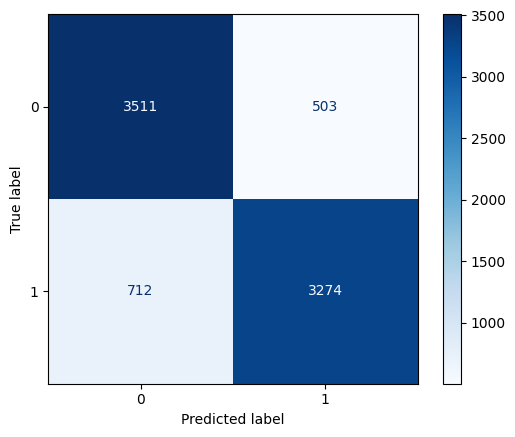

Execution time: 121.72101974487305 seconds


In [44]:
xgb_model = xgb.XGBClassifier(random_state = 0)
xgb_model.fit(embeddings_x_train_df, y_train)
pred_xgb = xgb_model.predict(embeddings_x_val_df)
pred_xgb_prob = xgb_model.predict_proba(embeddings_x_val_df)

In [ ]:
create_summary_for_model_metrics(y_val, pred_xgb, pred_xgb_prob[:,1])